In [1]:
import torch
import import_ipynb

from model import UNet3D
from data_loader import BrainTumorDataset

importing Jupyter notebook from model.ipynb
importing Jupyter notebook from data_loader.ipynb


In [2]:
import torch.nn.functional as F

#refrence: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class IoULoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
ALPHA = 0.8
GAMMA = 2
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

dice_loss = DiceLoss()
focal_loss = FocalLoss()
iou_score = IoULoss()

    

In [3]:
def load_trained_model(model_path, device):
    model = UNet3D(in_channels=4, num_classes=4)
    model.load_state_dict(torch.load(model_path,weights_only=False))
    model.to(device)
    model.eval()
    return model

In [4]:
def validate_iou(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            
            dice = dice_loss(outputs, masks)
            focal = focal_loss(outputs, masks)
            loss = dice + focal
            
            total_loss += loss.item()
            # Calculate IoU score
            pred = torch.argmax(outputs, dim=1)
            masks = torch.argmax(masks, dim=1)
            total_iou += iou_score(pred, masks)
    
    avg_loss = total_loss / len(dataloader)
    avg_iou = total_iou / len(dataloader)
    return avg_loss, avg_iou

In [5]:
from torch.utils.data import DataLoader

#Set up dataset and dataloader
val_img_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\images\\'
val_mask_dir  = '.\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\masks\\'

val_dataset = BrainTumorDataset(val_img_dir, val_mask_dir)

batch_size = 1
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_path = 'trained_3d_unet_for_brain_tumor_segmentation.pth'
model= load_trained_model(model_path, device)
val_loss, val_iou = validate_iou(model, val_loader, device)

Using device: cuda


In [6]:
print("val_loss :",val_loss)
print("val_iou :",val_iou.item())

val_loss : 0.6535414146340411
val_iou : 0.8568274974822998


In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np

img_num = 350
image = torch.load(f".\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\images\\image_{img_num}.pt",weights_only=False).numpy()
true_mask = torch.load(f".\BraTS20\BraTS2020_TrainingData\input_data_4channels\\val\masks\\mask_{img_num}.pt",weights_only=False)
true_mask = true_mask.permute( 1, 2, 3, 0).numpy()
true_mask_argmax = np.argmax(true_mask, axis=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'trained_3d_unet_for_brain_tumor_segmentation.pth'

slice_num = 55

# Convert image to a torch tensor and add batch dimension
image_tensor = torch.tensor(image).unsqueeze(0).to(device)

# Make prediction
model = load_trained_model(model_path, device)
with torch.no_grad():
    output = model(image_tensor)

# Get the predicted mask

pred_mask= output[0].permute(1, 2, 3, 0).cpu().numpy()
pred_mask_argmax= np.argmax(pred_mask, axis=3)



In [41]:
print("pred_mask_argmax.shape", pred_mask_argmax.shape)
print("true_mask_argmax.shape", true_mask_argmax.shape)

pred_mask_argmax.shape (128, 128, 128)
true_mask_argmax.shape (128, 128, 128)


Text(0.5, 1.0, 'Prediction')

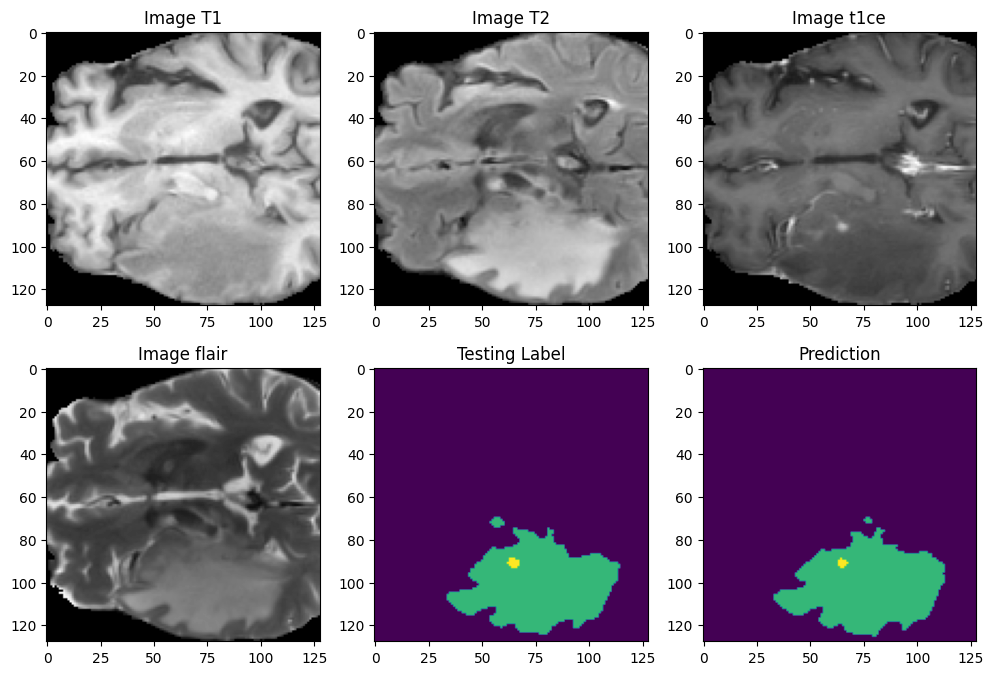

In [42]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(image.transpose(1, 2, 3, 0)[:, :, slice_num, 0], cmap='gray')  
plt.title('Image T1')

plt.subplot(232)
plt.imshow(image.transpose(1, 2, 3, 0)[:, :, slice_num, 1], cmap='gray')  
plt.title('Image T2')

plt.subplot(233)
plt.imshow(image.transpose(1, 2, 3, 0)[:, :, slice_num, 2], cmap='gray')  
plt.title('Image t1ce')

plt.subplot(234)
plt.imshow(image.transpose(1, 2, 3, 0)[:, :, slice_num, 3], cmap='gray')  
plt.title('Image flair')

plt.subplot(235)
plt.imshow(true_mask_argmax[:, :, slice_num])
plt.title('Testing Label')


plt.subplot(236)
plt.imshow(pred_mask_argmax[:, :, slice_num])
plt.title('Prediction')